# Hands on with PyMC
Let's practice everything we have learned this morning about **Value conversions** and implement them using the `PyMC` library.

As before, we only workout the case of two variants A and B with **Value conversions**. For now, we don't use real data yet and simply assume synthetic trials and successes.

## Value Conversions


So far we have compared A and B variants in terms of how many conversions they generate, and estimated the relative uplift of conversions between the two.

Now what if we wanted to compare A and B variants in terms of how much revenue they generate, and estimate the relative uplift of revenue between the two. 

Suppose that a single visitor $i$ has a probability $\theta$ of paying at all. So, we can write the following model:

$$conv_i \sim \mathrm{Bernoulli}(\theta)$$ 

$$\theta \sim \mathrm{Beta}(\alpha_1, \beta_1)$$

This is already the Bernoulli conversion model we have seen before. What is new in the Value Conversion model is the following:

We assume that if a visitor pays, they spend an amount $rev$ that is exponentially distributed with rate $\lambda$:

$$rev_i \sim \mathrm{Exponential}(\lambda)$$

$$\lambda \sim \mathrm{Gamma}(\alpha_2, \beta_2)$$

In this setting, we have two priors, one for $\theta$ and one for $\lambda$. So, we need two likelihoods, one for $conv_i$ and one for $rev_i$. By combining the two priors and likelihoods, we can estimate two posteriors, one for $\theta$ and one for $\lambda$.

The reach our objective which is finding the relative uplift of revenue between A and B we will use the posterior samples of $\theta$ and $\lambda$. The expected revenue per visitor is $\theta/\lambda$.




Let's extend the setting for more than just a single visitor:

\begin{align*}
conv &=  \sum^{\# \text{visitors}} conv_i \\
&= \sum^{\# \text{visitors}}\mathrm{Bernoulli}(\theta)
\sim \mathrm{Binomial}(\# \text{visitors}, \theta)
\end{align*}

\begin{align*}
rev &= \sum^{\# \text{payers}} rev_i \\
&= \sum^{\# \text{payers}}\mathrm{Exponential}(\lambda)
\sim \mathrm{Gamma}(\# \text{payers}, \lambda)
\end{align*}

Let's complete the setting by bringing in the variants A and B:

We have two conversion **likelihoods**:

\begin{align*}
conv_A &\sim \mathrm{Binomial}(N_A, \theta_A) \\
conv_B &\sim \mathrm{Binomial}(N_B, \theta_B) \\
\end{align*}

and our **prior** about conversion probablies are:

$$\theta_A = \theta_B \sim \mathrm{Beta}(\alpha_1, \beta_1)$$

We have two revenue **likelihoods**:

\begin{align*}
rev_A &\sim \mathrm{Gamma}(conv_A, \lambda_A) \\
rev_B &\sim \mathrm{Gamma}(conv_B, \lambda_B)
\end{align*}

ad our **prior** about the amounts spent are:

$$\lambda_A = \lambda_B \sim \mathrm{Gamma}(\alpha_2, \beta_2)$$

Finally, average spending by two variants are:

$$\mu_A =  \dfrac{\theta_A}{\lambda_A}$$
$$\mu_B =  \dfrac{\theta_B}{\lambda_B}$$

and the relative uplift is:

$$\mathrm{uplift} = \mu_B / \mu_A - 1$$

Note: $\mu$ here represents the average revenue per visitor, including those who don't make a purchase. This is the best way to capture the overall revenue effect - some variants may increase the average sales value, but reduce the proportion of visitors that pay at all (e.g. if we promoted more expensive items on the landing page).

Below we put this setup into `PyMC` framework and find the posteriors.

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc as pm

In [2]:
# Set random seed
rng = np.random.default_rng(4000)
# Set plotting style
plotting_defaults = dict(bins=50,kind="hist",textsize=8,)

## Your First Try

In [3]:
# as before we have variants A and B
variants  = ['A', 'B']

In [97]:
# let's define the revenue data
# each variant has 1000 visitors 
visitors      = [1000, 1000]

# 100 of which leads to purchase, i.e. conversion rate is 10%
purchased     = [100, 100]

# each purchase is worth 10, i.e. mean purchase is 10
total_revenue = [1000, 1000]

In [6]:
# let's define parameters for a prior for the conversion rates
conv_alpha, conv_beta = [5000, 5000]

In [5]:
# let's define parameters for the mean purchase prior
purchase_alpha, purchase_beta = [9000, 900]

In [110]:
with pm.Model() as example_model:

    #------------------------------------------------conversion rate model
    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = conv_alpha, 
                    beta  = conv_beta, 
                    shape = 2)
    
    # Likelihood of observations
    converted = pm.Binomial("converted", 
                            n        = visitors,      # total visitors
                            observed = purchased,     # total visitors converted
                            p        = theta,         # chance they convert
                            shape    = 2)  
    
    #------------------------------------------------revenue model
    # Priors for unknown model parameters
    lamda = pm.Gamma( "lamda", 
                    alpha = purchase_alpha,
                    beta  = purchase_beta,
                    shape = 2)
    
    # Likelihood of observations
    revenue = pm.Gamma("revenue", 
                        alpha    = purchased,            # total visitors converted
                        observed = total_revenue, 
                        beta     = lamda, 
                        shape    = 2)        
    
    # get the revenue per visitor
    revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta / lamda)

    #------------------------------------------------relative uplifts
    theta_uplift = pm.Deterministic(f"theta uplift", theta[1] / theta[0] - 1)
    lamda_uplift = pm.Deterministic(f"lamda uplift", (1 / lamda[1]) / (1 / lamda[0]) - 1)
    uplift       = pm.Deterministic(f"uplift", revenue_per_visitor[1] / revenue_per_visitor[0] - 1)

    #------------------------------------------------posterior
    # draw posterior samples
    trace = pm.sample(draws=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.


In [99]:
# Check the unobserved random variables:
example_model.unobserved_RVs    

[theta ~ Beta(5e+03, 5e+03),
 lamda ~ Gamma(9e+03, f()),
 revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [100]:
# Check the observed (synthetic) random variable:
example_model.observed_RVs  

[converted ~ Binomial(<constant>, theta),
 revenue ~ Gamma(<constant>, f(lamda))]

In [101]:
# Check the deterministic random variable:
example_model.deterministics

[revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [102]:
# check the trace, i.e. posterior distribution of the conversion rates
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [103]:
# find out the shape of all trace.posterior variables
for var in trace.posterior:
    print(var, trace.posterior[var].shape)

theta (4, 10000, 2)
lamda (4, 10000, 2)
revenue_per_visitor (4, 10000, 2)
theta uplift (4, 10000)
lamda uplift (4, 10000)
uplift (4, 10000)


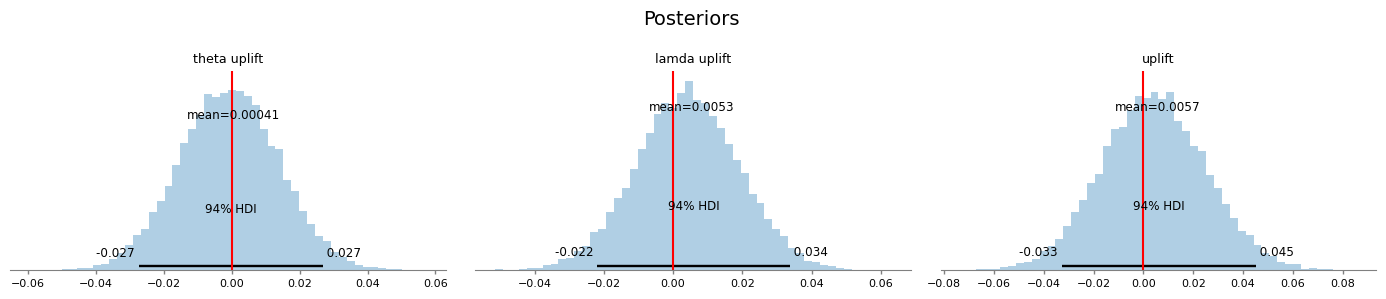

In [111]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **plotting_defaults)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

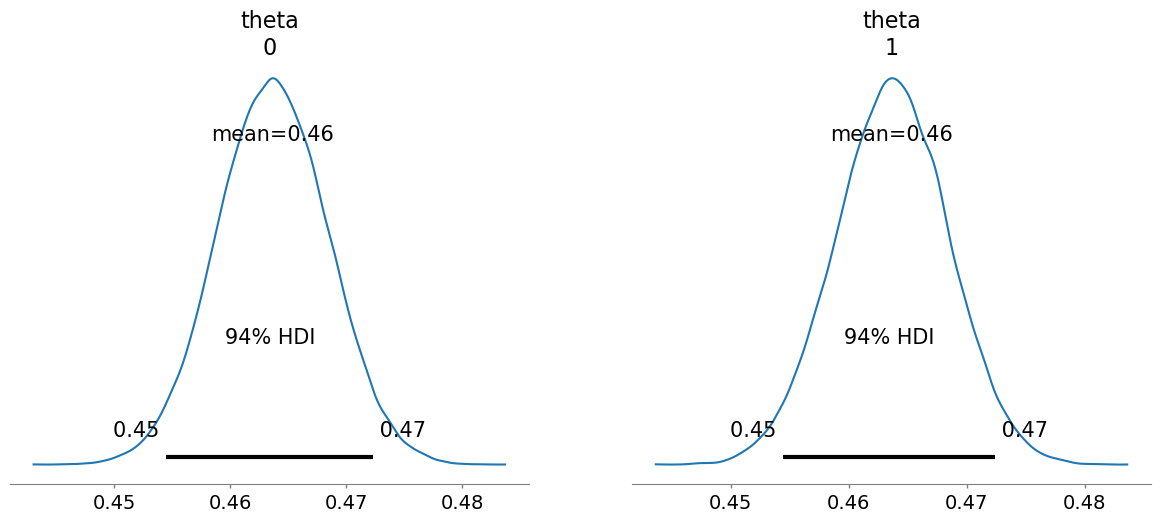

In [105]:
# plot the posterior of the conversion rates
az.plot_posterior(trace, var_names=["theta"]);

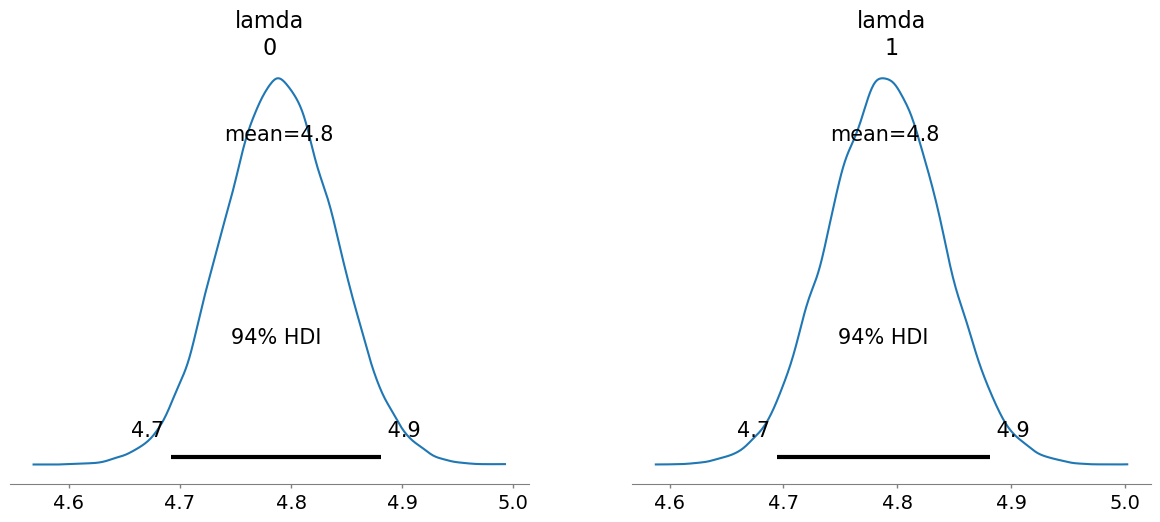

In [106]:
# plot the posterior of the mean purchase
az.plot_posterior(trace, var_names=["lamda"]);

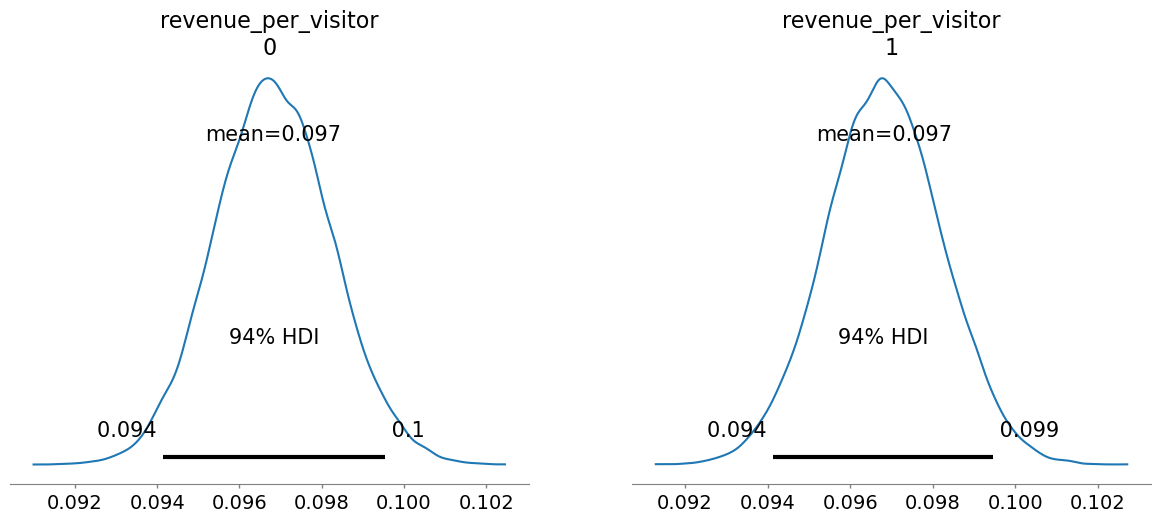

In [107]:
# plot the posterior of the mean purchase
az.plot_posterior(trace, var_names=["revenue_per_visitor"]);

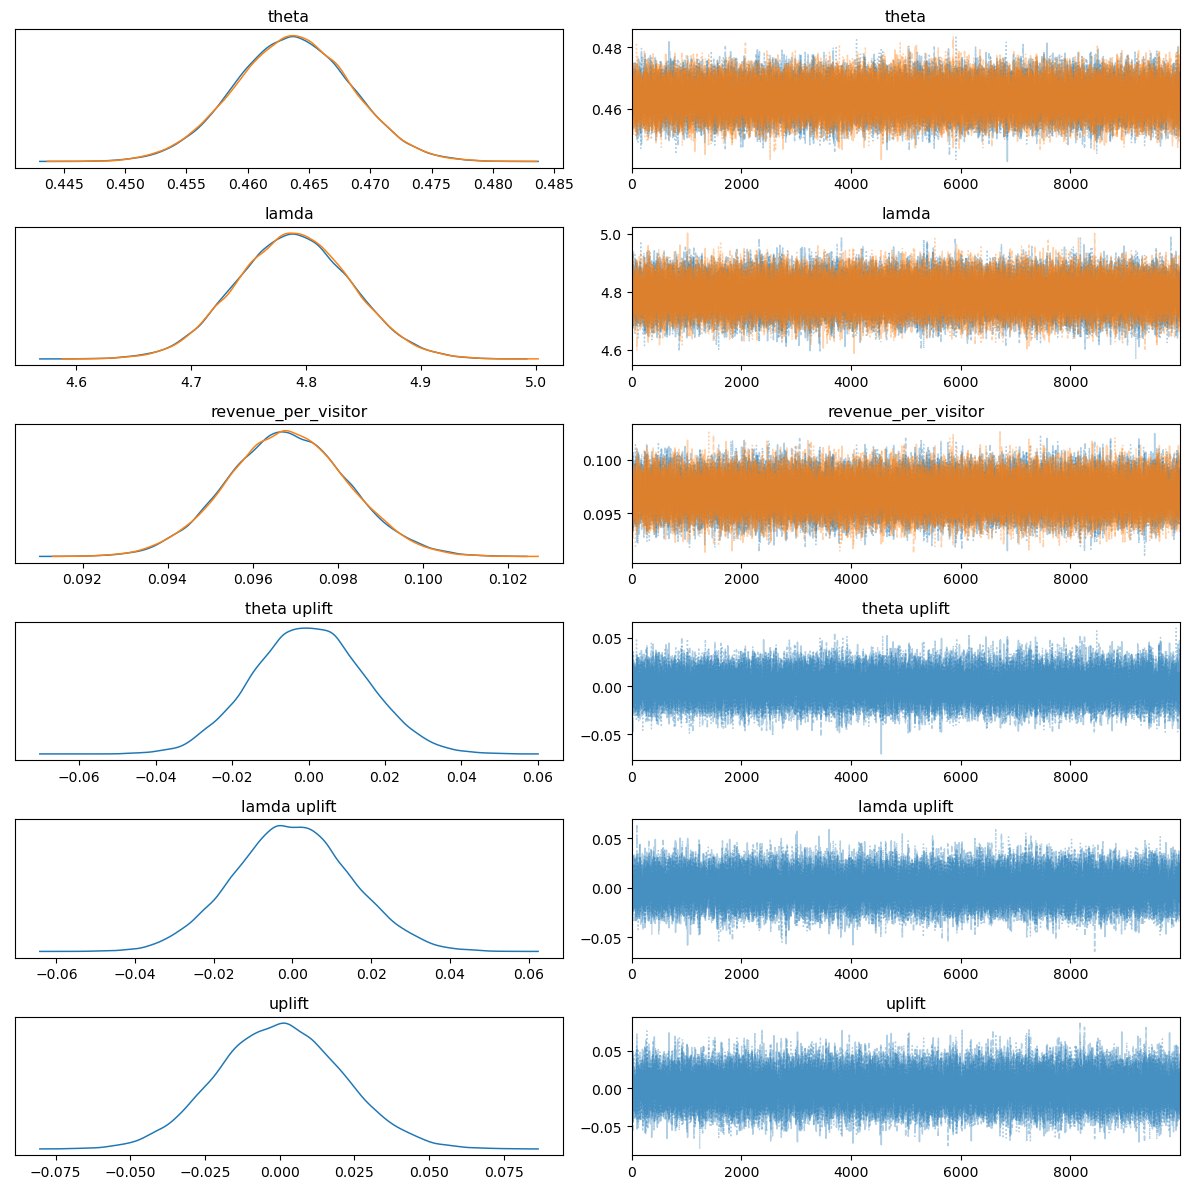

In [108]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

## Your Second Try

Note that so far we have set up the number of `purchased` and `total_revenue` as absolute values. We will now change them to be random variables. 

To generate them as random variables, we need to specify `conversion_rates` and `mean_purchase`. To see how to do this you can check the `get_data` function in the `tools.py` file in the same directory.

In [53]:
%run -i tools.py

Let's suppose that variant B's visitors are less likely to purchase: $$\theta_B=8\% < \theta_A=10\%$$

But their mean purchase value is higher: 

$$\frac{1}{\lambda_B}=12.5 > \frac{1}{\lambda_A}=10$$

Remember that the expected revenue per visitor was $\frac{\theta}{\lambda}$. So, in this scenario both variants have the same expected revenue per visitor:

$$ 0.08 \times 12.5 =  0.10 \times 10$$

Therefore, the relative uplift should be zero because 

$$\mathrm{uplift} = \frac{0.08 \times 12.5}{0.10 \times 10} - 1 = 0$$


In [45]:
# let's increase the sample size to 100,000 
visitors = [100000, 100000]

# conversion_rates [10%, 8%]  
conversion_rates = [0.1, 0.08]

# mean_purchase 
mean_purchase    = [10, 12.5]

In [46]:
purchased, total_revenue = get_data(['A', 'B'], conversion_rates, mean_purchase, 100000)

generated 100000 obs from a Bernoulli rv based on 0.1 rate for variant A
generated 100000 obs from an Exponential rv based on 10 for variant A
----------------------------------------------------------------------
generated 100000 obs from a Bernoulli rv based on 0.08 rate for variant B
generated 100000 obs from an Exponential rv based on 12.5 for variant B
----------------------------------------------------------------------

 Below is the outcome and we are now going to use them as input in the PyMC model:


,A,B
visitors,100000.0,100000.0
purchased,10063.0,8018.0
total_revenue,99501.0,100412.0


Let's keep the priors the same as before:

In [47]:
# let's define parameters for a weak prior for the conversion rates
conv_alpha, conv_beta = [5000, 5000]

# let's define parameters for the mean purchase prior
purchase_alpha, purchase_beta = [9000, 900]

In [50]:
trace =  get_posterior2(beta_priors  = [conv_alpha, conv_beta], 
                        gamma_priors = [purchase_alpha, purchase_beta],
                        visitors     = 100000, 
                        purchased    = purchased,
                        total_revenue= total_revenue)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.


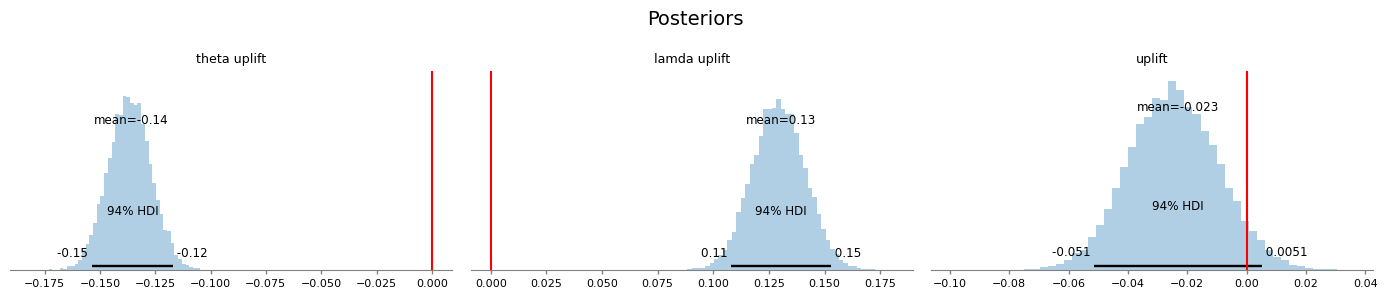

In [51]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **plotting_defaults)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

- What do you learn from the posterior distribution of uplift for $\theta$?
- What do you learn from the posterior distribution of uplift for $\lambda$?
- What do you learn from the posterior distribution of uplift for $\frac{\theta}{\lambda}$? did you expect its HDI to include zero?

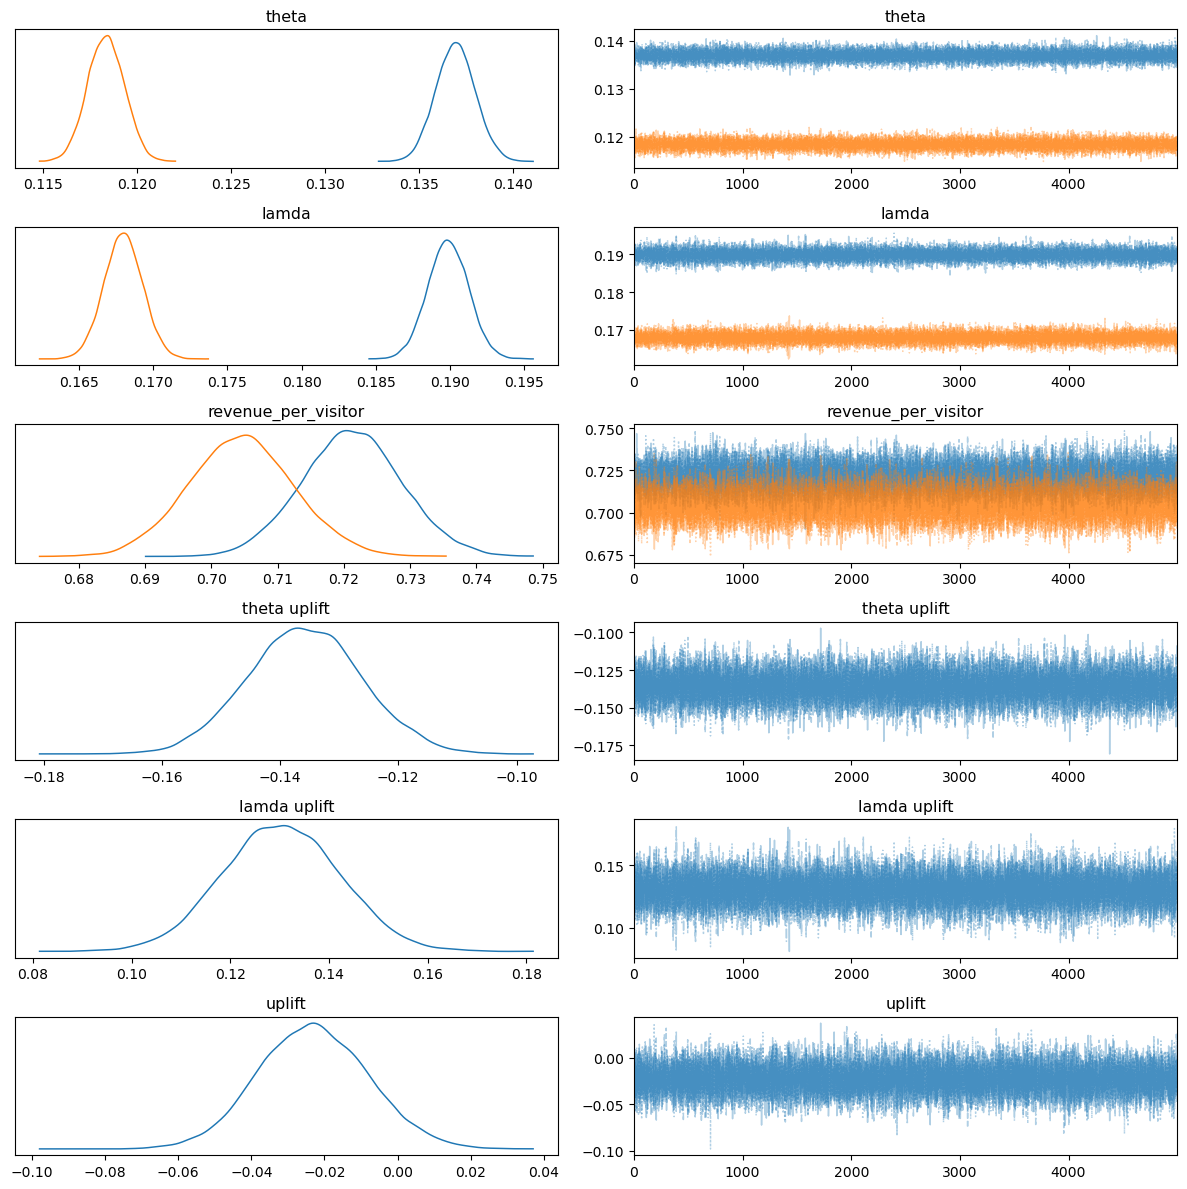

In [52]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

## Your third Try
Higher propensity to purchase and higher mean purchase value, and overall higher revenue per visitor

Let's suppose that variant B's visitors are more likely to purchase: $$\theta_B=11\% > \theta_A=10\%$$

And their mean purchase value is higher: 

$$\frac{1}{\lambda_B}=10.5 > \frac{1}{\lambda_A}=10$$

Remember that the expected revenue per visitor was $\frac{\theta}{\lambda}$. So, in this scenario both variants have the same expected revenue per visitor:

$$ 0.11 \times 10.5 >  0.10 \times 10$$

Therefore, the relative uplift should be zero because 

$$\mathrm{uplift} = \frac{1.155}{1} - 1 > 0$$


In [54]:
# conversion_rates [10%, 11%]  
conversion_rates = [0.1, 0.11]

# mean_purchase 
mean_purchase    = [10, 10.5]

In [55]:
purchased, total_revenue = get_data(['A', 'B'], conversion_rates, mean_purchase, 100000)

generated 100000 obs from a Bernoulli rv based on 0.1 rate for variant A
generated 100000 obs from an Exponential rv based on 10 for variant A
----------------------------------------------------------------------
generated 100000 obs from a Bernoulli rv based on 0.11 rate for variant B
generated 100000 obs from an Exponential rv based on 10.5 for variant B
----------------------------------------------------------------------

 Below is the outcome and we are now going to use them as input in the PyMC model:


,A,B
visitors,100000.0,100000.0
purchased,10144.0,11057.0
total_revenue,101892.0,116364.0


In [56]:
trace =  get_posterior2(beta_priors  = [conv_alpha, conv_beta], 
                        gamma_priors = [purchase_alpha, purchase_beta],
                        visitors     = 100000, 
                        purchased    = purchased,
                        total_revenue= total_revenue
                        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [theta, lamda]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.


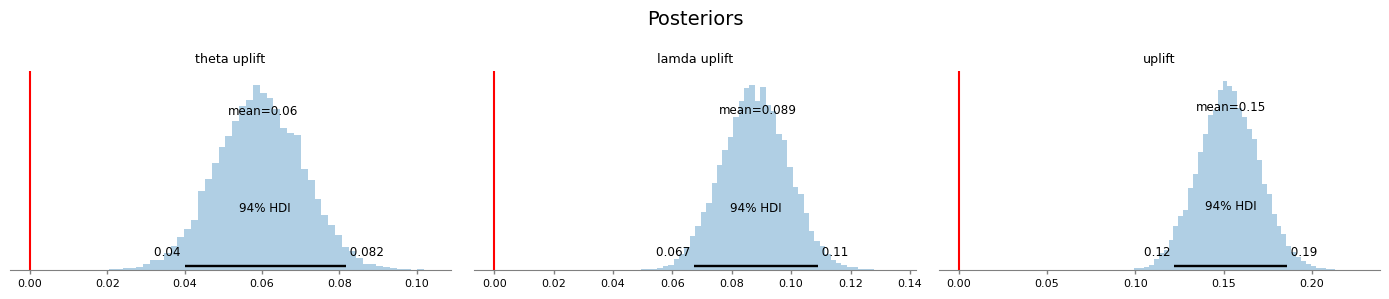

In [57]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **plotting_defaults)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

- What do you learn from the posterior distribution of uplift for $\theta$?
- What do you learn from the posterior distribution of uplift for $\lambda$?
- What do you learn from the posterior distribution of uplift for $\frac{\theta}{\lambda}$? did you expect its HDI not containig zero?

Assumption: 

- conversion probability is independent to the mean amount spent when paying. This is a typical assumption in practice
